In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import casadi as cas
plt.style.use('seaborn')

C:\Users\aless\AppData\Local\Temp\ipykernel_18080\418906186.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
# Model
dt = 0.01
X = cas.SX.sym('X', 3)
Eps = cas.SX.sym('Eps', 2)
U = cas.SX.sym('U', 2)
F = cas.vertcat((X[0]) + (cas.cos(X[2]) * (U[0] + Eps[0]) *dt ),
     (X[1]) + (cas.sin(X[2]) * (U[0] + Eps[0]) *dt),
     (X[2]) + (U[1] + Eps[1]) * dt)

In [5]:
A = cas.jacobian(F, X)
G = cas.jacobian(F, Eps)
A_fun = cas.Function('A_fun', [X, U, Eps], [A])
G_fun = cas.Function('G_fun', [X, U, Eps], [G])
F_fun = cas.Function('F_fun', [X, U, Eps], [F])

In [6]:
A

SX(@1=1, @2=0.01, 
[[@1, 00, (-(@2*((U_0+Eps_0)*sin(X_2))))], 
 [00, @1, (@2*((U_0+Eps_0)*cos(X_2)))], 
 [00, 00, @1]])

In [7]:
N = 10000

x0 = np.array([0, 0, 0])
x_hat = np.zeros((3, N))
x_true = np.zeros((3, N))

P = np.zeros((3, 3, N))
P[:,:,0] = np.eye(3) * 0
x_hat[:,0] = x0
x_true[:,0] = x0

u = np.array([1, 0.01])


H = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]])

sigma_xi_x = 1
sigma_u = 1

eps = np.random.multivariate_normal([0, 0], np.eye(2) * sigma_u**2, N).T
xi = np.random.multivariate_normal([0, 0, 0], np.eye(3) * sigma_xi_x**2, N).T


for i in range(N-1):
    # Compute ground truth
    x_true[:,i+1] = F_fun(x_true[:,i], u, 0*eps[:,i]).full().flatten()

    
    A = A_fun(x_hat[:,i], u, eps[:,i]).full()
    G = G_fun(x_hat[:,i], u, eps[:,i]).full()
    Q = np.eye(2) * sigma_u**2
    R = np.eye(3)*sigma_xi_x**2

    

    # Prediction step
    x_hat[:,i+1] = F_fun(x_hat[:,i], u, eps[:,i]).full().flatten()
    P[:,:, i+1] = A @ P[:,:,i] @ A.T + G @ Q @ G.T

    # Update step
    z = H @ x_true[:,i] + xi[:,i]
    s = H @ P[:,:,i+1] @ H.T + R
    w = P[:,:,i+1] @ H.T @ np.linalg.inv(s)
    x_hat[:,i+1] = x_hat[:,i+1] + (w @ (z.T - H @ x_hat[:,i+1]))
    P[:,:,i+1] =  (np.eye(3) - w @ H) @ P[:,:,i+1]


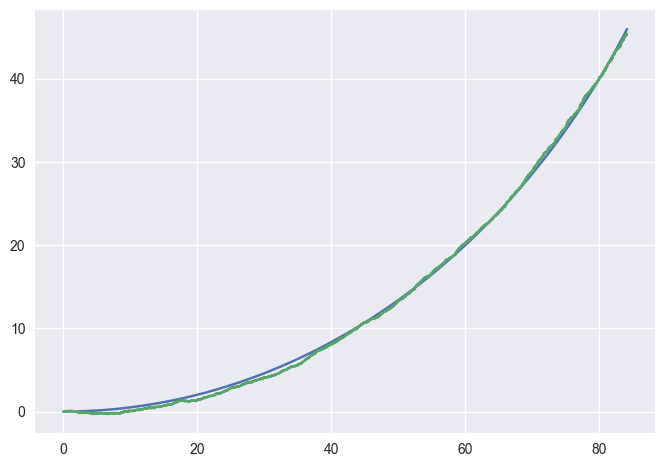

In [8]:
plt.plot(x_true[0,:], x_true[1,:])
plt.plot(x_hat[0,:], x_hat[1,:])
# plt.legend(['True', 'Estimate'])